# INFO-4604 Final Project 

* Created by Garrett Glissmann on November 17, 2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import nltk
# Installing English pickle: https://stackoverflow.com/a/10852888
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

dfMovies = pd.read_csv('tmdb_5000_movies_out_final.csv', sep=',', header=0, encoding='latin1')
# dfMovies.head()

In [2]:
class ClassifySteps:
    def __init__(self, dataframe, cols_X, cols_Y, test_size=0.2):
        self.cols_X, self.cols_Y = cols_X, cols_Y
        self.df_movies_x = dataframe[cols_X].fillna("")
        self.df_movies_y = dataframe[cols_Y].fillna("")
        self.random_state = 123        
        self.test_size = test_size
        self.cols_Y_N = len(cols_Y)
        self.percentiles = [1,5,10,30,50,70,90,100]
        self.n_comp = [10,50,80,100,150,200]
        
        self.Y_train = False
        self.Y_test = False
        
        self.best_acc = 0
        self.best_model = False
        self.best_y_predict = False
        
        self.classifiers = ['DecisionTree', 'MLP', 'RandomForest']
        self.y_plot_acc = self.per_y = self.lsa_y = False
    
    def reset_plot_data(self):
        lists = [[] for i in range(len(self.classifiers))]
        self.y_plot_acc = dict(zip(self.classifiers, lists))
    
    def start(self):
        print("Multi-label classification:\n\tLabels: {}\n\tFeatures: {}".format(self.cols_Y, self.cols_X))
        X_train, X_test, Y_train, Y_test = train_test_split(
            self.df_movies_x, 
            self.df_movies_y, 
            test_size=self.test_size, 
            random_state=self.random_state
        )
        
        self.Y_train = Y_train
        self.Y_test = Y_test

        print("Tokenize")

        vect = DictVectorizer()
        X_train_final = vect.fit_transform(self.nltk_features(row) for index, row in X_train.iterrows())
        X_test_final = vect.transform(self.nltk_features(row) for index, row in X_test.iterrows())

        print("Transformed")

        self.start_selections(X_train_final, X_test_final)
        self.start_lsa(X_train_final, X_test_final)
        
        if (self.best_model != False):
            print("\n******** Best ********\n")
            print("Best model\n", self.best_model.best_estimator_)
            print("Best validation accuracy: ", self.best_acc)
            test_acc = accuracy_score(self.Y_test, self.best_y_predict)
            print("Test accuracy: %0.6f" % test_acc)
    
    def select_percentile_data(self, percen, x_train, x_test):
        selection = SelectPercentile(percentile=percen, score_func=chi2)
        x_train_per = selection.fit_transform(x_train, self.Y_train)
        x_test_per = selection.transform(x_test)
        return x_train_per, x_test_per
            
    def select_lsa_data(self, comp, x_train, x_test):
        dim_red = TruncatedSVD(n_components=comp, random_state=self.random_state)
        x_train_lsa = dim_red.fit_transform(x_train, self.Y_train)
        x_test_lsa = dim_red.transform(x_test)
        return x_train_lsa, x_test_lsa

    def nltk_features(self, row):
        sentence = "{}. {}. {}".format(row["original_title"], row["overview"], row["tagline"]).lower()
        tokens = nltk.word_tokenize(sentence)
        return Counter(tokens)

    def grid_search(self, base_classifier, params, x_train, x_test, key):    
        gs_classifier = GridSearchCV(base_classifier, params, cv=5)
        gs_classifier.fit(x_train, self.Y_train)
        y_predict = gs_classifier.predict(x_test)
        valid_acc = gs_classifier.best_score_
        
        self.y_plot_acc[key].append(valid_acc)

        print("\tValidation accuracy: %0.6f" % valid_acc)
        
        if (valid_acc > self.best_acc):
            self.best_acc = valid_acc
            self.best_model = gs_classifier
            self.best_y_predict = y_predict

    def do_classifiers(self, x_train, x_test):
        print("\t--- Decision Tree ---")
        dt = DecisionTreeClassifier(random_state=self.random_state)
        params = {}
        self.grid_search(dt, params, x_train, x_test, 'DecisionTree')

        print("\n\t--- Random Forest ---")
        rf = RandomForestClassifier(random_state=self.random_state)
        params = {}
        self.grid_search(rf, params, x_train, x_test, 'RandomForest')

#         print("\n\t--- Multi-layered perceptron ---")
#         mlp = MLPClassifier(random_state=self.random_state)
#         params = {
#             'hidden_layer_sizes': [(200)] # , (300), (100)
#         }
#         self.grid_search(mlp, params, x_train, x_test, 'MLP')

    def start_selections(self, x_train_start, x_test_start):
        self.reset_plot_data()
        for per in self.percentiles:
            print("\n------------------------------------\nFeature selection - percentile: {}\n".format(per))
            x_train, x_test = self.select_percentile_data(per, x_train_start, x_test_start)
            self.do_classifiers(x_train, x_test)
        self.per_y = self.y_plot_acc
    
    def start_lsa(self, x_train_start, x_test_start):
        self.reset_plot_data()
        for comp in self.n_comp:
            print("\n------------------------------------\nLSA - components: {}\n".format(comp))
            x_train_lsa, x_test_lsa = self.select_lsa_data(comp, x_train_start, x_test_start)
            self.do_classifiers(x_train_lsa, x_test_lsa)
        self.lsa_y = self.y_plot_acc
        
    def do_plot(self, ax, x_vals, y_vals):
        colors = dict(zip(self.classifiers, ['r', 'g', 'b']))
        for label in self.classifiers:
            plot_vals = y_vals[label]
            if (len(plot_vals) > 0):
                ax.plot(x_vals, plot_vals, colors[label], label=label)
            
    def do_plots(self):
        # Percentiles
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        self.do_plot(ax, self.percentiles, self.per_y)
        ax.grid(alpha=0.25)
        ax.set_axisbelow(True)
        ax.set_title('Classifiers Using Feature Selection')
        ax.legend(loc='lower right', shadow=True)
        ax.set_xlabel('Percentiles')
        ax.set_ylabel('Validation Accuracy')
        # LSA
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        self.do_plot(ax, self.n_comp, self.lsa_y)
        ax.grid(alpha=0.25)
        ax.set_axisbelow(True)
        ax.set_title('Classifiers Using LSA')
        ax.legend(loc='lower right', shadow=True)
        ax.set_xlabel('N-components')
        ax.set_ylabel('Validation Accuracy')

In [3]:
cols_X, cols_Y = ['original_title', 'overview', 'tagline'], []
for c in dfMovies.columns:
    if (c.find('genres_') == 0):
        cols_Y.append(c)

# This set of genres in a greater accuracy
cols_Y = ['genres_action', 'genres_adventure', 'genres_fantasy']
# cols_Y = ['genres_action', 'genres_comedy', 'genres_romance']

classify = ClassifySteps(dfMovies, cols_X, cols_Y)
classify.start()

Multi-label classification:
	Labels: ['genres_action', 'genres_adventure', 'genres_fantasy']
	Features: ['original_title', 'overview', 'tagline']
Tokenize
Transformed

------------------------------------
Feature selection - percentile: 1

	--- Decision Tree ---
	Validation accuracy: 0.564289

	--- Random Forest ---
	Validation accuracy: 0.649401

------------------------------------
Feature selection - percentile: 5

	--- Decision Tree ---
	Validation accuracy: 0.594482

	--- Random Forest ---
	Validation accuracy: 0.669443

------------------------------------
Feature selection - percentile: 10

	--- Decision Tree ---
	Validation accuracy: 0.600469

	--- Random Forest ---
	Validation accuracy: 0.670484

------------------------------------
Feature selection - percentile: 30

	--- Decision Tree ---
	Validation accuracy: 0.599948

	--- Random Forest ---
	Validation accuracy: 0.667361

------------------------------------
Feature selection - percentile: 50

	--- Decision Tree ---
	Valid

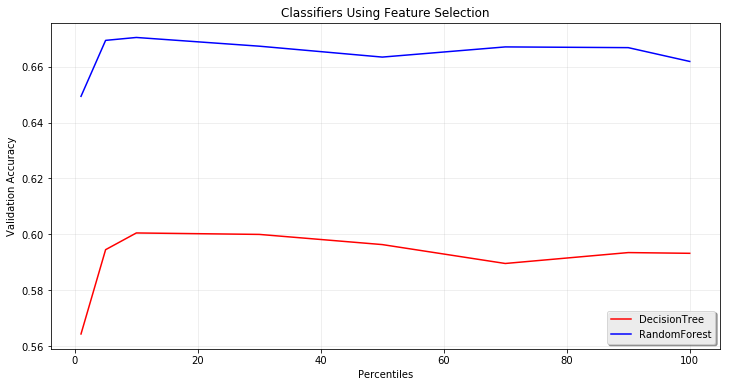

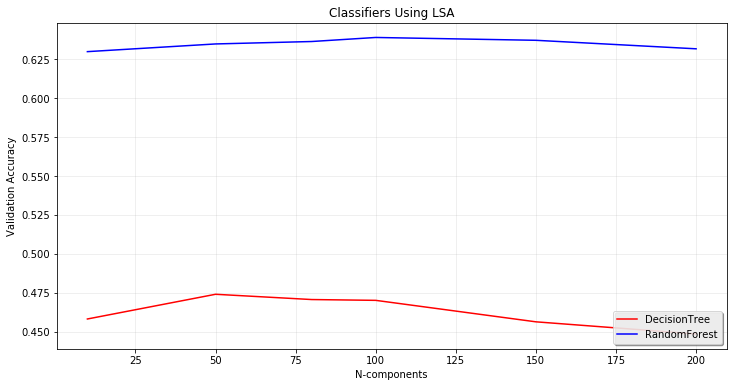

In [4]:
classify.do_plots()